In [1]:
%matplotlib inline


Plot Combinations of Raster Bands Using EarthPy
===================================================
Learn how to plot different band combinations from satellite imagery using EarthPy


Create Composite Images Using EarthPy
---------------------------------------------

<div class="alert alert-info"><h4>Note</h4><p>The examples below will show you how to use the ``plot_rgb()``
   function from EarthPy to plot different band combinations and
   create composite images from satellite imagery such as Landsat.</p></div>

A color image consists of three band channels displayed together: red, green,
and blue. Some remote sensing datasets such as Landsat collect data across
many spectral bands and are stored with each band in a separate file. These
bands can be combined to create true color composites (or RGB images) as well
as color infrared (CIR) composites, which highlight vegetation in the image.
To create an RGB image, you need to plot the red, green, and blue bands,
respectively, such that red band is plotted on the red channel, green on the
green, etc. In a color infrared image (sometimes called a false color image),
the near-infrared (NIR) band is plotted on the red channel. Thus,
vegetation, which reflects strongly in the NIR part of the electromagnetic
spectrum, will appear "red" in the resulting composite image.

The example below walks you through a typical workflow for plotting different
band combinations to create RGB (true color) and CIR (false color) composite
images. You will create a stack of bands using Landsat 8 data and then plot
the different band combinations using the ``plot_rgb()`` function. You will
also learn how to stretch the image values to brighten dark images, how to
overlay polygon boundaries on the images, and how to create figures that
contain multiple plots.



Import Packages
------------------------------

To begin, import the needed packages. You will use a combination of several
EarthPy modules including spatial and plot.



In [2]:
import os
from glob import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

Import and Stack Example Data
------------------------------
To plot band combinations and create composite images using ``plot_rgb()``,
the bands of a satellite image such as those from Landsat, need to be stacked
into one file. With EarthPy, you can create an image stack from all of the
Landsat .tif files (one per band) in a directory using the ``stack()`` function
from the ``earthpy.spatial`` module.



Error found on Windows systems
-------------------------------
<div class="alert alert-info"><h4>Note</h4><p>If you are running this script on a Windows system, there is a
      known bug with ``.to_crs()``, which is used in this script. If an error
      occurs, you have to reset your os environment with the command
      ``os.environ["PROJ_LIB"] = r"path-to-share-folder-in-environment"``.</p></div>



In [3]:
# Get sample data from EarthPy and set working directory
data_path = et.data.get_data("vignette-landsat")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

# Get list of bands and sort by ascending band number
landsat_bands_data_path = "data/vignette-landsat/LC08_L1TP_034032_20160621_20170221_01_T1_sr_band*[1-7]*.tif"
stack_band_paths = glob(landsat_bands_data_path)
stack_band_paths.sort()

# Create image stack and apply nodata value for Landsat
arr_st, meta = es.stack(stack_band_paths, nodata=-9999)

Plot RGB Composite Image
--------------------------
You can use the ``plot_rgb()`` function from the ``earthpy.plot`` module to quickly
plot three band composite images. For RGB composite images, you will plot the red,
green, and blue bands, which are bands 4, 3, and 2, respectively, in the image
stack you created. Python uses a zero-based index system, so you need to subtract
a value of 1 from each index. Thus, the index for the red band is 3, green is 2,
and blue is 1. These index values are provided to the ``rgb`` argument to identify
the bands for the composite image.



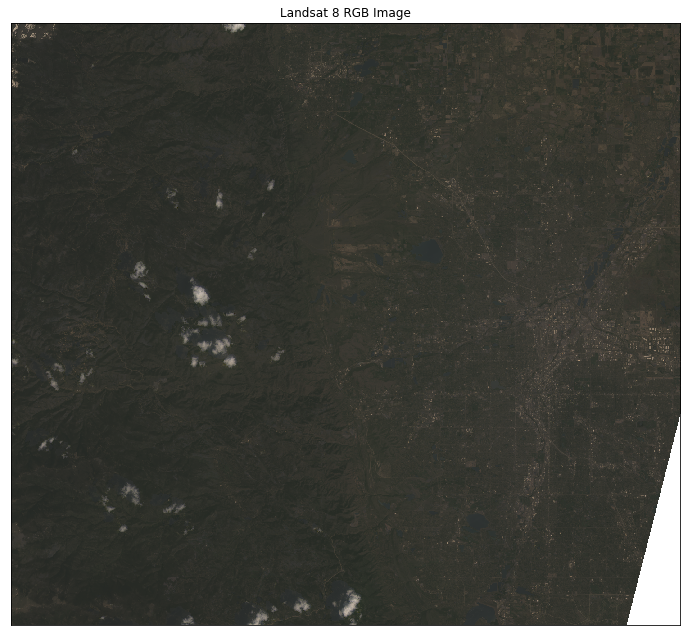

In [4]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot red, green, and blue bands, respectively
ep.plot_rgb(arr_st, rgb=(3, 2, 1), ax=ax, title="Landsat 8 RGB Image")
plt.show()

Stretch Composite Images
-------------------------
Composite images can sometimes be dark if the pixel brightness values are
skewed toward the value of zero. You can stretch the pixel brightness values
in an image using the argument ``stretch=True`` to extend the values to the
full 0-255 range of potential values to increase the visual contrast of the
image. In addition, the ``str_clip`` argument allows you to specify how much of
the tails of the data that you want to clip off. The larger the number, the
more the data will be stretched or brightened.



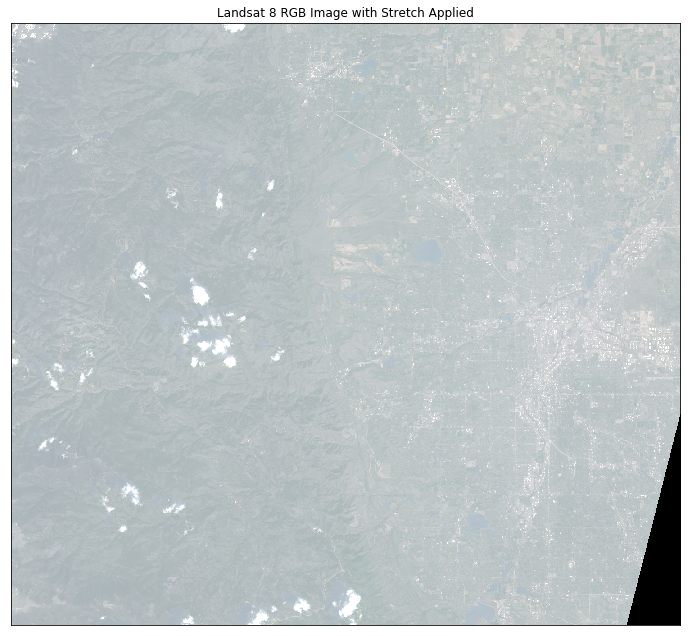

In [5]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot bands with stretched applied
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="Landsat 8 RGB Image with Stretch Applied",
)
plt.show()

Plot Color Infrared (CIR) Composite Image
------------------------------------------
For color infrared (CIR) composite images, you will plot the near-infrared (NIR),
red, and green bands, which are bands 5, 4, 2, respectively. Once again, the
Python index values will be the original band number minus 1, thus, 4, 3, and 2
for NIR, red, and green, respectively.



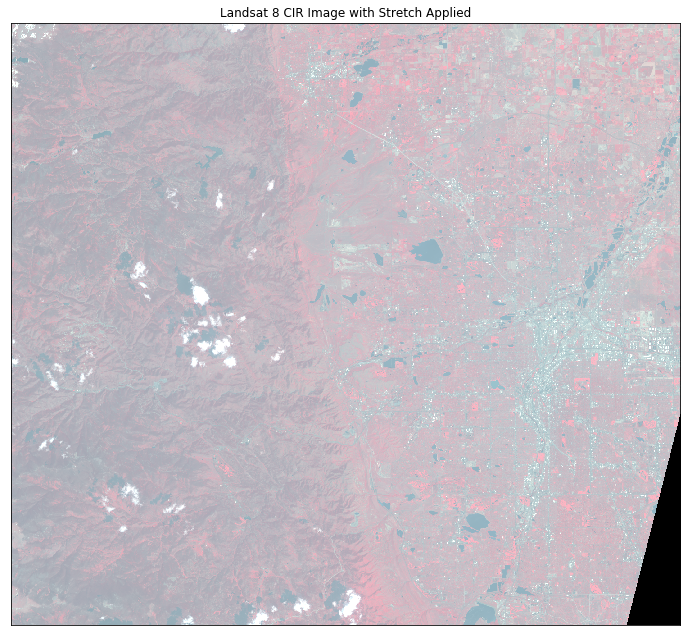

In [6]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot NIR, red, and green bands, respectively, with stretch
ep.plot_rgb(
    arr_st,
    rgb=(4, 3, 2),
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="Landsat 8 CIR Image with Stretch Applied",
)
plt.show()

Plot Boundary Over Composite Image
-----------------------------------
<div class="alert alert-info"><h4>Note</h4><p>If you are on windows, you may need to add the crs issue discussed above
      here!</p></div>

You can overlay a polygon boundary on top of an RGB plot created with EarthPy.
To begin, the raster data and the boundary need to be in the same
Coordinate Reference System (CRS). You can reproject the boundary layer to
match the CRS of the image by getting the CRS of the image from the Rasterio
profile object and passing that CRS to the ``to_crs`` method from GeoPandas.



In [7]:
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

# Open polygon boundary using GeoPandas
bound = gpd.read_file(
    "data/vignette-landsat/vector_layers/fire-boundary-geomac/co_cold_springs_20160711_2200_dd83.shp"
)

# Reproject boundary to match CRS of the Landsat images
with rio.open(stack_band_paths[0]) as raster_crs:
    raster_profile = raster_crs.profile
    bound_utm13N = bound.to_crs(raster_profile["crs"])

Create a Plot With the Boundary overlayed on the RGB Image 
----------------------------------------------------------
You can plot a polygon boundary over an image by creating a raster extent
for the plot using the ``plotting_extent`` function from ``rasterio.plot``.
The function needs the Rasterio profile of the image and a single layer of a
numpy array, which can be specified with ``arr_str[0]``. The function also
needs the spatial transformation for the Rasterio object, which can be acquired
by accessing the ``"transform"`` key within the Rasterio profile.



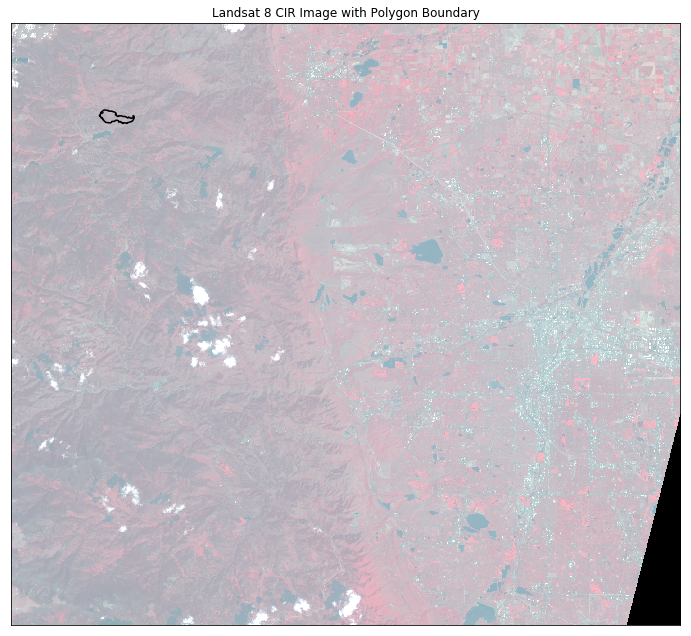

In [8]:
# Create raster extent for the plot
extent = plotting_extent(arr_st[0], raster_profile["transform"])

# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot boundary with high zorder for contrast
bound_utm13N.boundary.plot(ax=ax, color="black", zorder=10)

# Plot CIR image using the raster extent
ep.plot_rgb(
    arr_st,
    rgb=(4, 3, 2),
    ax=ax,
    stretch=True,
    extent=extent,
    str_clip=0.5,
    title="Landsat 8 CIR Image with Polygon Boundary",
)
plt.show()

Create Figure with Multiple Axes or Subplots
--------------------------------------------
```plot_rgb()`` has an ``ax=`` parameter which supports subplots. You can 
create figures that contain multiple plots by creating multiple ax
objects, one for each plot. You can also specify the number of rows and
columns in which to display the plots. In the example below, the two plots
will be displayed side-by-side along one row with two columns.



In [ ]:
# Create figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot of RGB composite image with polygon boundary
bound_utm13N.boundary.plot(ax=ax1, color="black", zorder=10)
ax1 = ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    ax=ax1,
    stretch=True,
    extent=extent,
    str_clip=0.5,
    title="Landsat 8 RGB Image with Polygon Boundary",
)

# Plot of CIR composite image with polygon boundary
bound_utm13N.boundary.plot(ax=ax2, color="black", zorder=10)
ax2 = ep.plot_rgb(
    arr_st,
    rgb=(4, 3, 2),
    ax=ax2,
    stretch=True,
    extent=extent,
    str_clip=0.5,
    title="Landsat 8 CIR Image with Polygon Boundary",
)
plt.show()